In [60]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

https://machinelearningmastery.com/training-the-transformer-model/

https://machinelearningmastery.com/training-the-transformer-model/

In [61]:
from keras.optimizers import Adam
from keras.metrics import Mean
from tensorflow import data, train, GradientTape, function

from novel.transformer.components.transformer import TransformerModel
from novel.transformer.components.utils import LRScheduler, loss_fcn, accuracy_fcn, likelihood_fcn
from novel.transformer.components.example_dataset import PrepareDataset

from time import time

In [62]:
# Define the model parameters

h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

# Define the training parameters
epochs = 2
batch_size = 8
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1

# Instantiate an Adam optimizer
optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)

# Prepare the training and test splits of the dataset
dataset = PrepareDataset()
trainX, trainY, train_orig, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = dataset('english-german-both.pkl')
print(f'X Length: {trainX.shape}')

# Prepare the dataset batches
train_dataset = data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(batch_size)

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)

# Include metrics monitoring
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')
train_likelihood = Mean(name='train_likelihood')

# Create a checkpoint object and manager to manage multiple checkpoints
ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=3)

predictions = []
targets = []
losses = []

# Speeding up the training process
@function
def train_step(encoder_input, decoder_input, decoder_output):
    with GradientTape() as tape:
        prediction = training_model(encoder_input, decoder_input, training=True)

        loss = loss_fcn(decoder_output, prediction)
        accuracy = accuracy_fcn(decoder_output, prediction)
        likelihood = likelihood_fcn(decoder_output, prediction)

    gradients = tape.gradient(loss, training_model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))

    train_loss(loss)
    train_accuracy(accuracy)
    train_likelihood(likelihood)

    return loss, prediction, decoder_output

train_loss.reset_states()
train_accuracy.reset_states()
train_likelihood.reset_states()

print(f"\nStart of training in {len(train_dataset)} batches")

start_time = time()

for step, (train_batchX, train_batchY) in enumerate(train_dataset):
    encoder_input = train_batchX[:, 1:]
    decoder_input = train_batchY[:, :-1]
    decoder_output = train_batchY[:, 1:]

    loss, prediction, target = train_step(encoder_input, decoder_input, decoder_output)

    losses.append(loss.numpy())
    predictions.append(prediction.numpy())
    targets.append(decoder_output.numpy())

    if step % 25 == 0:
        print(f'Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f} Likelihood {train_likelihood.result():.4f}')

# Print epoch number and loss value at the end of every epoch
print("Training Loss %.4f, Training Accuracy %.4f, Training Likelihood %.4f" % (train_loss.result(), train_accuracy.result(), train_likelihood.result()))

print("Total time taken: %.2fs" % (time() - start_time))

X Length: (9000, 7)

Start of training in 1125 batches
Step 0 Loss 8.3713 Accuracy 0.0000 Likelihood 0.0003
Step 25 Loss 8.1657 Accuracy 0.0429 Likelihood 0.0004
Step 50 Loss 7.7102 Accuracy 0.1281 Likelihood 0.0038
Step 75 Loss 7.3719 Accuracy 0.1590 Likelihood 0.0133
Step 100 Loss 7.1319 Accuracy 0.1748 Likelihood 0.0196
Step 125 Loss 6.9503 Accuracy 0.1844 Likelihood 0.0247
Step 150 Loss 6.7988 Accuracy 0.1901 Likelihood 0.0291
Step 175 Loss 6.6486 Accuracy 0.1974 Likelihood 0.0358
Step 200 Loss 6.4969 Accuracy 0.2090 Likelihood 0.0470
Step 225 Loss 6.3732 Accuracy 0.2164 Likelihood 0.0559
Step 250 Loss 6.2601 Accuracy 0.2231 Likelihood 0.0635
Step 275 Loss 6.1643 Accuracy 0.2279 Likelihood 0.0697
Step 300 Loss 6.0828 Accuracy 0.2302 Likelihood 0.0753
Step 325 Loss 6.0033 Accuracy 0.2335 Likelihood 0.0804
Step 350 Loss 5.9351 Accuracy 0.2376 Likelihood 0.0853
Step 375 Loss 5.8671 Accuracy 0.2415 Likelihood 0.0898
Step 400 Loss 5.8042 Accuracy 0.2449 Likelihood 0.0942
Step 425 Loss 5

In [63]:
len(predictions)

1125

In [64]:
predictions[0].shape

(8, 11, 3661)

In [65]:
targets[0].shape

(8, 11)

In [66]:
print(losses)

[8.371279, 8.379585, 8.382248, 8.275523, 8.342092, 8.382625, 8.253298, 8.29826, 8.344342, 8.470945, 8.357046, 8.331581, 8.169255, 8.091899, 8.152474, 8.278178, 8.142634, 8.121732, 8.101543, 8.047036, 8.129571, 7.958352, 7.7159576, 7.7270904, 7.7545485, 7.730174, 7.781246, 7.7392545, 7.6929045, 7.5877604, 7.467393, 7.455424, 7.495265, 7.3208704, 7.264243, 7.395447, 7.275898, 7.280961, 7.125142, 7.0394206, 7.0167384, 7.067264, 7.1097426, 6.911839, 7.0427055, 6.886701, 7.078149, 6.982023, 7.0814633, 6.871462, 6.942145, 6.9162245, 6.805571, 6.7615395, 6.81489, 6.8194504, 6.709177, 6.7506514, 6.8577394, 6.6752396, 6.876278, 6.6685815, 6.5924277, 6.5784144, 6.7349563, 6.8152666, 6.6432, 6.6742697, 6.8103294, 6.4859567, 6.584277, 6.194213, 6.378675, 6.7201133, 6.654556, 6.5184317, 6.6181893, 6.408856, 6.7853603, 6.673132, 6.597847, 6.330836, 6.414965, 6.291281, 6.222417, 6.365004, 6.068979, 6.3167186, 6.3699446, 6.2654395, 6.3568187, 6.4259048, 6.290786, 6.359436, 6.331906, 6.272172, 6.410129

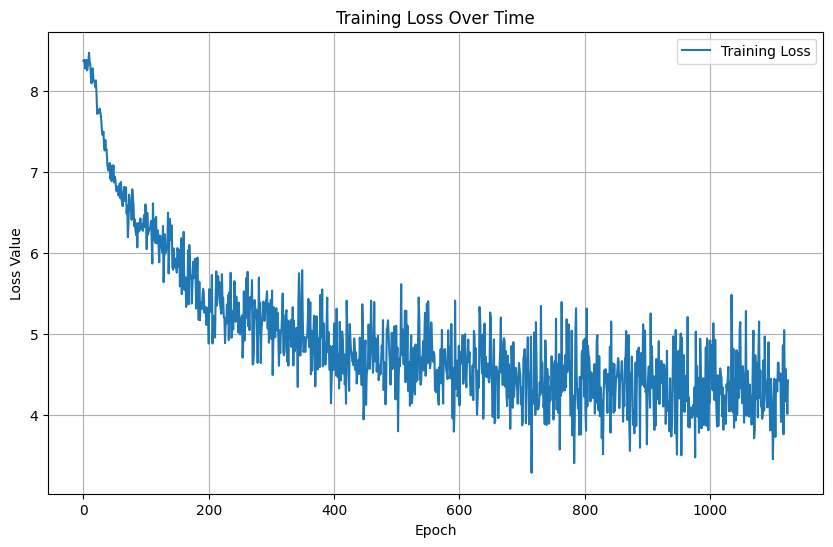

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()